In [152]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import DataCollatorWithPadding, GPT2Tokenizer, DistilBertForSequenceClassification, DistilBertModel, DistilBertTokenizer, TrainingArguments, Trainer, TrainingArguments
from datasets import load_metric
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, accuracy_score
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
import random
import wandb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib



In [153]:
estimators = 100
do_label_same_size_sample = False

# RFR TIMESPLIT

In [154]:
# Load data 
dataFrame = pd.read_csv('digitalizações_registadas.csv', 
                       delimiter=";",
                       date_format="", 
                       parse_dates=['Data Emissão','Data entrada','Data vencimento indicada'])  

# Strip any leading or trailing whitespace from column names
dataFrame.columns = dataFrame.columns.str.strip()

# Get unnamed columns to remove
unnamed_columns = [col for col in dataFrame.columns if col.startswith('Unnamed')]

# Drop unnamed columns
dataFrame = dataFrame.drop(columns=unnamed_columns)

# Drop rows with any null values
dataFrame = dataFrame.dropna(subset=['Data vencimento indicada','Data Emissão','Origem']) #'Contrato'
# Drop specific row with date in year 221
dataFrame = dataFrame[dataFrame['Nº documento Fornecedor'] != "ZRF2 2/6001001951"]

dataFrame['Data Emissão'] = pd.to_datetime(dataFrame['Data Emissão'], format="%d/%m/%Y")
dataFrame['Data entrada'] = pd.to_datetime(dataFrame['Data entrada'], format="%d/%m/%Y")
dataFrame['Data vencimento indicada'] = pd.to_datetime(dataFrame['Data vencimento indicada'], format="%d/%m/%Y")

dataFrame['Valor com IVA'] = dataFrame['Valor com IVA'].str.replace(',', '').astype(float)


In [155]:
dataFrame = dataFrame[dataFrame['Origem'] != "Requisição"]
dataFrame['Labels'] = dataFrame['Origem']

In [156]:
if do_label_same_size_sample:
    grouped = dataFrame.groupby('Labels')
    min_size = grouped.size().min()
    dataFrame = grouped.apply(lambda x: x.sample(min_size)).reset_index(drop=True)

In [157]:
# Feature Engineering
dataFrame['MonthEmissão'] = dataFrame['Data Emissão'].dt.month
dataFrame['DayOfWeekEmissão'] = dataFrame['Data Emissão'].dt.dayofweek

dataFrame['MonthEntrada'] = dataFrame['Data entrada'].dt.month
dataFrame['DayOfWeekEntrada'] = dataFrame['Data entrada'].dt.dayofweek

dataFrame['MonthVencimento'] = dataFrame['Data vencimento indicada'].dt.month
dataFrame['DayOfWeekVencimento'] = dataFrame['Data vencimento indicada'].dt.dayofweek

In [158]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None
np.random.seed(seed)
random.seed(seed)

In [159]:
# encode data
label_encoder = LabelEncoder()

dataFrame_before_2024 = dataFrame[dataFrame['Data entrada'] < '2024-01-01']
dataFrame_after_2024 = dataFrame[dataFrame['Data entrada'] >= '2024-01-01']

print(len(dataFrame))
print(len(dataFrame_before_2024))
print(len(dataFrame_after_2024))

train_labels = dataFrame_before_2024['Labels'].tolist()
test_labels = dataFrame_after_2024['Labels'].tolist()

encoded_labels_train = label_encoder.fit_transform(train_labels)
encoded_labels_test = label_encoder.fit_transform(test_labels)


dataFrame_before_2024 = dataFrame_before_2024.drop(["Labels","Estado",
                   "Data Emissão","Data vencimento indicada",
                   "Data entrada","Origem","Nº documento Fornecedor",
                   "Nº Encomenda","Âmbito de Compra"], axis=1)

dataFrame_before_2024['Fornecedor'] = label_encoder.fit_transform(dataFrame_before_2024['Fornecedor'])


dataFrame_after_2024 = dataFrame_after_2024.drop(["Labels","Estado",
                   "Data Emissão","Data vencimento indicada",
                   "Data entrada","Origem","Nº documento Fornecedor",
                   "Nº Encomenda","Âmbito de Compra"], axis=1)

dataFrame_after_2024['Fornecedor'] = label_encoder.fit_transform(dataFrame_after_2024['Fornecedor'])


# fit model
#model = RandomForestRegressor(n_estimators=estimators, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(dataFrame_before_2024, encoded_labels_train)


# Evaluate random forest regressor
predictions = model.predict(dataFrame_after_2024)

mae = mean_absolute_error(encoded_labels_test, predictions)
print('Mean Absolute Error:', mae)


# Calculate MSE
mse = mean_squared_error(encoded_labels_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate R-squared
r2 = r2_score(encoded_labels_test, predictions)
print(f'R-squared (R²): {r2}')


# Calculate accuracy
accuracy = sum(1 for true, pred in zip(encoded_labels_test, predictions) if true == pred) / len(encoded_labels_test)
print(f'Accuracy: {accuracy * 100:.2f}%')


31101
25692
5409
Mean Absolute Error: 0.09169902015159918
Mean Squared Error (MSE): 0.09169902015159918
R-squared (R²): -0.1738558591196555
Accuracy: 90.83%


In [175]:
dataFrame_before_2024

,Fornecedor,Valor com IVA,MonthEmissão,DayOfWeekEmissão,MonthEntrada,DayOfWeekEntrada,MonthVencimento,DayOfWeekVencimento
5986,782,2332000.0,12,4,12,4,12,0
6646,609,26322.0,11,0,12,4,11,0
6647,664,354855.0,12,3,12,4,12,3
6648,354,41526.0,12,3,12,4,12,3
6649,45,12398.0,12,2,12,4,1,3
...,...,...,...,...,...,...,...,...
40687,492,155288.0,12,3,12,0,3,2
40688,492,14986.0,12,3,12,0,3,2
40689,268,27768.0,12,4,12,0,1,6
40691,268,555.0,12,4,12,0,1,6


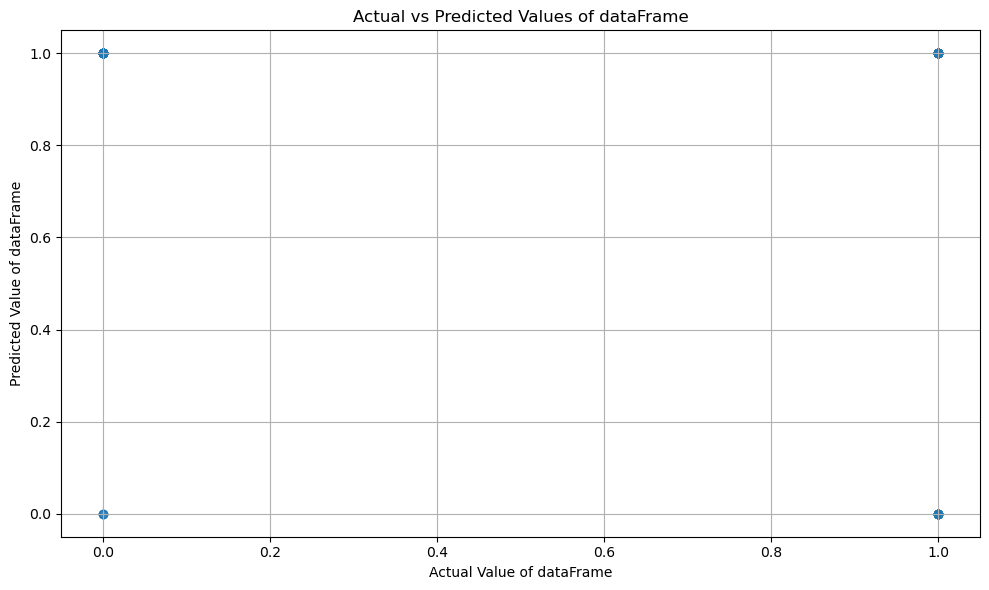

In [160]:
plt.figure(figsize=(10, 6))
plt.scatter(encoded_labels_test, predictions, alpha=0.1)
plt.xlabel('Actual Value of dataFrame')
plt.ylabel('Predicted Value of dataFrame')
plt.title('Actual vs Predicted Values of dataFrame')
plt.grid(True)
plt.tight_layout()
plt.show()

In [161]:
feature_importance = model.feature_importances_
feature_names = dataFrame_before_2024.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print('Feature Importance:')
print(feature_importance_df)

Feature Importance:
               Feature  Importance
0           Fornecedor    0.403875
1        Valor com IVA    0.263757
7  DayOfWeekVencimento    0.061059
5     DayOfWeekEntrada    0.059396
3     DayOfWeekEmissão    0.056808
4         MonthEntrada    0.054933
6      MonthVencimento    0.052806
2         MonthEmissão    0.047366


In [162]:
# Save the model to a file
joblib.dump(model, 'random_forest_classifier.pkl')

# Load the model from the file
loaded_rfc = joblib.load('random_forest_classifier.pkl')

# Make predictions on the test data using the loaded model
y_pred = loaded_rfc.predict(dataFrame_after_2024)

# Evaluate the loaded model
accuracy = accuracy_score(encoded_labels_test, y_pred)
report = classification_report(encoded_labels_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.9083009798484009
Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.04      0.07       462
           1       0.92      0.99      0.95      4947

    accuracy                           0.91      5409
   macro avg       0.59      0.52      0.51      5409
weighted avg       0.86      0.91      0.88      5409



# RFR NO TIMESPLIT

In [163]:
# Load data 
dataFrame = pd.read_csv('digitalizações_registadas.csv',
                       delimiter=";",
                       date_format="", 
                       parse_dates=['Data Emissão','Data vencimento indicada'])

# Strip any leading or trailing whitespace from column names
dataFrame.columns = dataFrame.columns.str.strip()

# Get unnamed columns to remove
unnamed_columns = [col for col in dataFrame.columns if col.startswith('Unnamed')]

# Drop unnamed columns
dataFrame = dataFrame.drop(columns=unnamed_columns)

# Drop rows with any null values
dataFrame = dataFrame.dropna(subset=['Data vencimento indicada','Data Emissão','Origem']) #'Contrato'
# Drop specific row with date in year 221
dataFrame = dataFrame[dataFrame['Nº documento Fornecedor'] != "ZRF2 2/6001001951"]

dataFrame['Data Emissão'] = pd.to_datetime(dataFrame['Data Emissão'], format="%d/%m/%Y")
dataFrame['Data entrada'] = pd.to_datetime(dataFrame['Data entrada'], format="%d/%m/%Y")
dataFrame['Data vencimento indicada'] = pd.to_datetime(dataFrame['Data vencimento indicada'], format="%d/%m/%Y")

dataFrame['Valor com IVA'] = dataFrame['Valor com IVA'].str.replace(',', '').astype(float)
#dataFrame = pd.get_dummies(dataFrame, columns=['Categoria'])

In [164]:
dataFrame = dataFrame[dataFrame['Origem'] != "Requisição"]
dataFrame['Labels'] = dataFrame['Origem']

In [165]:
if do_label_same_size_sample:
    grouped = dataFrame.groupby('Labels')
    min_size = grouped.size().min()
    dataFrame = grouped.apply(lambda x: x.sample(min_size)).reset_index(drop=True)

In [166]:
# Feature Engineering
dataFrame['MonthEmissão'] = dataFrame['Data Emissão'].dt.month
dataFrame['DayOfWeekEmissão'] = dataFrame['Data Emissão'].dt.dayofweek

dataFrame['MonthEntrada'] = dataFrame['Data entrada'].dt.month
dataFrame['DayOfWeekEntrada'] = dataFrame['Data entrada'].dt.dayofweek

dataFrame['MonthVencimento'] = dataFrame['Data vencimento indicada'].dt.month
dataFrame['DayOfWeekVencimento'] = dataFrame['Data vencimento indicada'].dt.dayofweek

In [167]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None
np.random.seed(seed)
random.seed(seed)

In [173]:
# Split the data into training and testing sets
X = dataFrame.drop(["Labels","Estado",
                   "Data Emissão","Data vencimento indicada",
                   "Data entrada","Origem","Nº documento Fornecedor",
                   "Nº Encomenda","Âmbito de Compra"], axis=1)

# Encode strings to integers
label_encoder = LabelEncoder()
X['Fornecedor'] = label_encoder.fit_transform(X['Fornecedor'])

y = label_encoder.fit_transform(dataFrame['Labels'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit
#model = RandomForestRegressor(n_estimators=estimators, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


# #val
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
print('Mean Absolute Error:', mae)

# Calculate MSE
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print(f'R-squared (R²): {r2}')


# Calculate accuracy
accuracy = sum(1 for true, pred in zip(y_test, predictions) if true == pred) / len(y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy SKlearn: {accuracy}")
print("Classification Report:")
print(report)

Mean Absolute Error: 0.06574505706478058
Mean Squared Error (MSE): 0.06574505706478058
R-squared (R²): 0.39039613401567863
Accuracy: 93.43%
Accuracy SKlearn: 0.9342549429352194
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.55      0.67       765
           1       0.94      0.99      0.96      5456

    accuracy                           0.93      6221
   macro avg       0.90      0.77      0.82      6221
weighted avg       0.93      0.93      0.93      6221



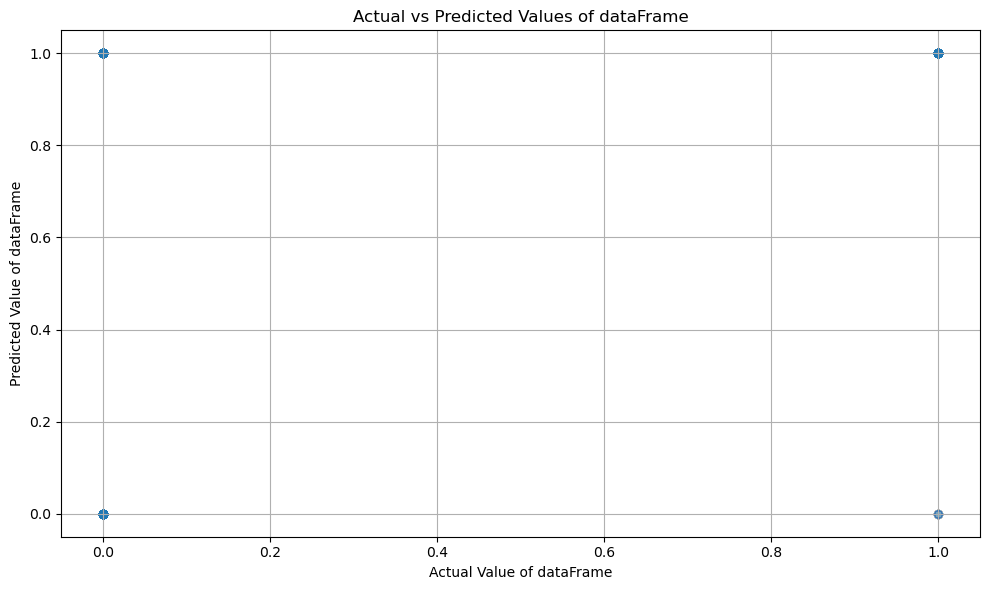

In [169]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.01)
plt.xlabel('Actual Value of dataFrame')
plt.ylabel('Predicted Value of dataFrame')
plt.title('Actual vs Predicted Values of dataFrame')
plt.grid(True)
plt.tight_layout()
plt.show()

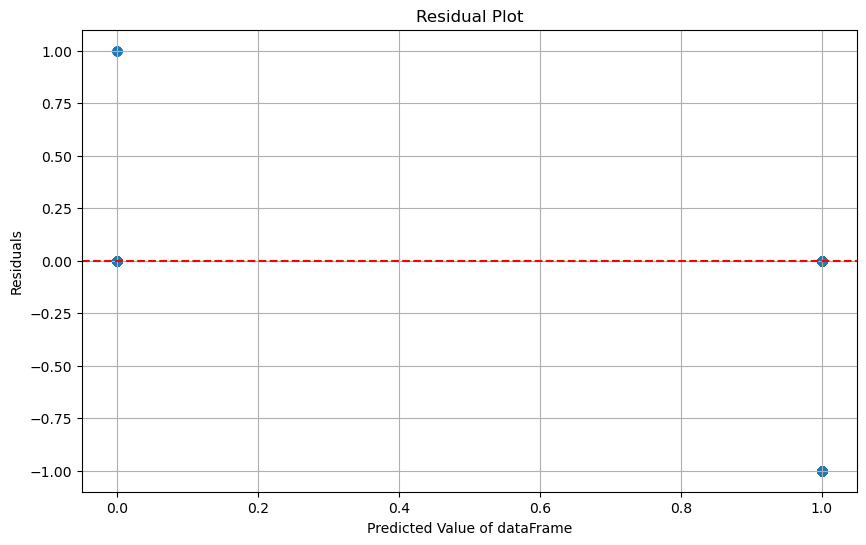

In [170]:
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
plt.scatter(predictions, residuals, alpha=0.5)
plt.xlabel('Predicted Value of dataFrame')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

In [171]:
feature_importance = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print('Feature Importance:')
print(feature_importance_df)

Feature Importance:
               Feature  Importance
0           Fornecedor    0.390613
1        Valor com IVA    0.266665
7  DayOfWeekVencimento    0.064244
3     DayOfWeekEmissão    0.060305
5     DayOfWeekEntrada    0.058501
4         MonthEntrada    0.056215
6      MonthVencimento    0.055987
2         MonthEmissão    0.047469


In [174]:
# Save the model to a file
joblib.dump(model, 'random_forest_classifier.pkl')

# Load the model from the file
loaded_rfc = joblib.load('random_forest_classifier.pkl')

# Make predictions on the test data using the loaded model
y_pred = loaded_rfc.predict(X_test)

# Evaluate the loaded model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

mae = mean_absolute_error(y_test, predictions)
print('Mean Absolute Error:', mae)

# Calculate MSE
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print(f'R-squared (R²): {r2}')

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Mean Absolute Error: 0.06574505706478058
Mean Squared Error (MSE): 0.06574505706478058
R-squared (R²): 0.39039613401567863
Accuracy: 0.9342549429352194
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.55      0.67       765
           1       0.94      0.99      0.96      5456

    accuracy                           0.93      6221
   macro avg       0.90      0.77      0.82      6221
weighted avg       0.93      0.93      0.93      6221



In [ ]:
# Making predictions (you can input your own data here)
new_data = pd.DataFrame({
    'Categoria_Custos': [False],
    'Categoria_Investimentos': [False],
    'Categoria_Proveitos': [False],
    'Categoria_Salários': [False],
    'Month': [6],
    'DayOfWeek': [1]
})
prediction = model.predict(new_data)
print('Predicted Value:', prediction[0])